In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Get data for all Test matches (March 8, 2004 - January 14, 2022) - compiled together from Cricsheet
data = pd.read_csv('all_matches.csv')

In [3]:
# Set basic info for desired player and his team
player = 'JE Root'
player_full_name = 'Joe Root'
player_short_name = 'Root'
team = 'England'
team_desc = 'English'

# Get all Test match IDs involving the player
player_test_ids = data[(data['striker'] == player)]['match_id'].unique()

# Get all Tests corresponding to the above IDs
player_tests = data[data['match_id'].isin(player_test_ids)]

# Get runs scored by the player in each match
player_runs = player_tests.groupby('match_id').apply(lambda player_match : 
                                     player_match[player_match['striker'] == player]['runs_off_bat'].sum())

# Get number of times the player was dismissed in each match
player_wickets = player_tests.groupby('match_id').apply(lambda player_match : 
                                     player_match[(player_match['player_dismissed'] == player) &
                                                (player_match['wicket_type'] != 'retired hurt')]['player_dismissed'].count())

In [4]:
# Return list of runs scored by other batsmen in the top 7 in each innings
def calc_other_runs(innings):
    top_7_batsmen = pd.unique(innings[['striker', 'non_striker']].values.ravel('K'))[:7]
    other_innings = innings[(innings['striker'] != player) & (innings['striker'].isin(top_7_batsmen))]
    return other_innings['runs_off_bat']

# Return list of other batsmen in the top 7 that were dismissed in each innings 
def calc_other_wickets(innings):
    # Handle case where no player was dismissed in an innings
    if(not innings['player_dismissed'].any()):
        return innings['player_dismissed'].head(1)
    
    top_7_batsmen = pd.unique(innings[['striker', 'non_striker']].values.ravel('K'))[:7]
    other_innings = innings[(innings['player_dismissed'] != player) & (innings['player_dismissed'].isin(top_7_batsmen)) & 
                           (innings['wicket_type'] != 'retired hurt')]
    return other_innings['player_dismissed']

# Get runs scored by other batsmen in the top 7 in each match
other_runs = player_tests[player_tests['batting_team'] == team].groupby([
    'match_id', 
    'innings'
]).apply(calc_other_runs).groupby('match_id').sum()

# Get number of times other batsmen in the top 7 were dismissed in each match
other_wickets = player_tests[player_tests['batting_team'] == team].groupby([
    'match_id', 
    'innings'
]).apply(calc_other_wickets).groupby('match_id').count()

In [5]:
# Compute the batting average of the player over time
player_matches = len(player_test_ids)
player_runs_sum = 0
player_wickets_sum = 0
player_avg_over_time = []

for i in range(player_matches):
    player_runs_sum += player_runs.array[i]
    player_wickets_sum += player_wickets.array[i]
    player_avg_over_time.append((player_runs_sum / player_wickets_sum).round(2))

In [6]:
# Compute the batting average of other batsmen in the top 7 over time
other_runs_sum = 0
other_wickets_sum = 0
other_avg_over_time = []

for i in range(player_matches):
    other_runs_sum += other_runs.array[i]
    other_wickets_sum += other_wickets.array[i]
    other_avg_over_time.append((other_runs_sum / other_wickets_sum).round(2))

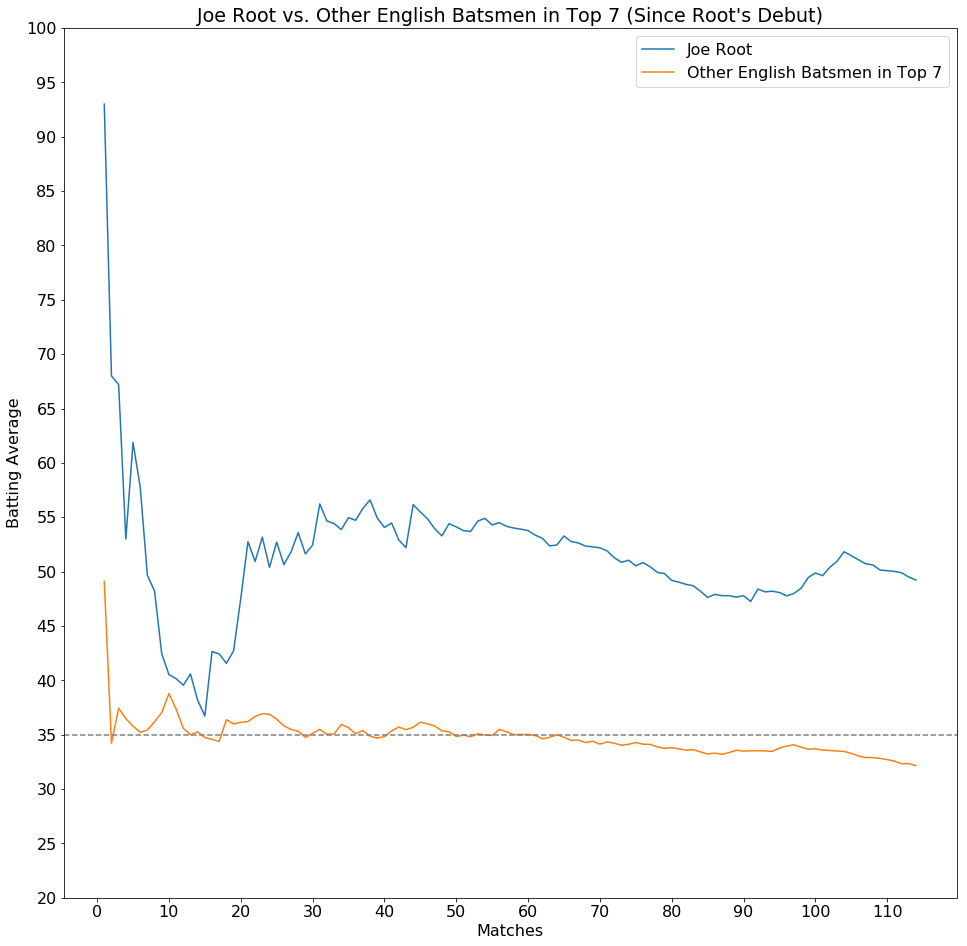

In [7]:
# Set up the plot
plt.figure(figsize = (16, 16))
plt.rcParams.update({'font.size': 16})
plt.title(player_full_name + ' vs. Other ' + team_desc + ' Batsmen in Top 7 (Since ' + player_short_name  + "'s Debut)")
plt.xlabel('Matches')
plt.ylabel('Batting Average')

# Plot the player's batting average vs. that of other batsmen in the top 7
plt.plot(range(1, player_matches + 1), player_avg_over_time)
plt.plot(range(1, player_matches + 1), other_avg_over_time)
plt.legend([player_full_name, 'Other ' + team_desc + ' Batsmen in Top 7'])

# Set ticks for x and y axes
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
plt.yticks(range(20, 105, 5))

# Mark the average of 35 for comparison purposes
plt.axhline(35, color = 'grey', linestyle = '--')

# Display the plot
plt.show()